# Generating Lyrics using LSTM

## Importing Libraries

In [1]:
import gc
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Dropout, LSTM, Dense, Bidirectional 
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from gensim.models import Word2Vec

from keras.callbacks import ModelCheckpoint

from keras.models import load_model
import pickle

2023-11-21 14:55:28.284378: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-21 14:55:28.284416: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-21 14:55:28.285279: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-21 14:55:28.365457: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Import and Process Dataset

In [2]:
origData = pd.read_csv("../lyrics-data.csv")
print(origData.shape)
origData.head()

(379931, 5)


,ALink,SName,SLink,Lyric,language
0,/ivete-sangalo/,Arerê,/ivete-sangalo/arere.html,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt
1,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Meu coração\nSem direção\nVoando só por voar\n...,pt
2,/ivete-sangalo/,Céu da Boca,/ivete-sangalo/chupa-toda.html,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt
3,/ivete-sangalo/,Quando A Chuva Passar,/ivete-sangalo/quando-a-chuva-passar.html,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt
4,/ivete-sangalo/,Sorte Grande,/ivete-sangalo/sorte-grande.html,A minha sorte grande foi você cair do céu\nMin...,pt


We will be needing only english songs

In [3]:
tempData = origData[origData.language == "en"].drop("language", axis = 1)
print(tempData.shape)
tempData.head()

(191814, 4)


,ALink,SName,SLink,Lyric
69,/ivete-sangalo/,Careless Whisper,/ivete-sangalo/careless-whisper.html,I feel so unsure\nAs I take your hand and lead...
86,/ivete-sangalo/,Could You Be Loved / Citação Musical do Rap: S...,/ivete-sangalo/could-you-be-loved-citacao-musi...,"Don't let them fool, ya\nOr even try to school..."
88,/ivete-sangalo/,Cruisin' (Part. Saulo),/ivete-sangalo/cruisin-part-saulo.html,"Baby, let's cruise, away from here\nDon't be c..."
111,/ivete-sangalo/,Easy,/ivete-sangalo/easy.html,"Know it sounds funny\nBut, I just can't stand ..."
140,/ivete-sangalo/,For Your Babies (The Voice cover),/ivete-sangalo/for-your-babies-the-voice-cover...,You've got that look again\nThe one I hoped I ...


There are still too many songs, let us narrow it down by selecting a few artists

In [4]:
select_artist = [
    "/green-day/",
    "/linkin-park/",
    "/imagine-dragons/",
    "/the-script/"
]
usedData = tempData[tempData.ALink.isin(select_artist)]

print(usedData.shape)
usedData.head()

(657, 4)


,ALink,SName,SLink,Lyric
142193,/linkin-park/,In The End,/linkin-park/in-the-end.html,"It starts with\nOne thing, I don't know why\nI..."
142194,/linkin-park/,Numb,/linkin-park/numb.html,I'm tired of being what you want me to be\nFee...
142195,/linkin-park/,Crawling,/linkin-park/crawling.html,"Crawling in my skin,\nThese wounds they will n..."
142196,/linkin-park/,Leave Out All The Rest,/linkin-park/leave-out-all-the-rest.html,I dreamed I was missing\nYou were so scared\nB...
142197,/linkin-park/,One More Light,/linkin-park/one-more-light.html,"Should've stayed, were there signs I ignored?\..."


### Cleaning and Visualising Data

We drop the Artist, Song name and Song Link columns since they are unused. Instead, we add a word count column

In [5]:
data = usedData.drop(["ALink", "SName", "SLink"], axis = 1)
data.head()

,Lyric
142193,"It starts with\nOne thing, I don't know why\nI..."
142194,I'm tired of being what you want me to be\nFee...
142195,"Crawling in my skin,\nThese wounds they will n..."
142196,I dreamed I was missing\nYou were so scared\nB...
142197,"Should've stayed, were there signs I ignored?\..."


In [6]:
data["NWords"] = data.Lyric.apply(lambda x: len(str(x).split()))
data = data[(data.NWords > 100) & (data.NWords < 450)]
data.NWords.max()

448

We delete variables which we do not intend to use later on to save on memory

In [7]:
del origData
del tempData
del usedData
del select_artist

Visualising the dataset thus formed

In [8]:
data.NWords.describe()

count    525.000000
mean     248.129524
std       86.807425
min      101.000000
25%      177.000000
50%      239.000000
75%      310.000000
max      448.000000
Name: NWords, dtype: float64

Text(0.5, 1.0, 'Word Count Distribution for Songs')

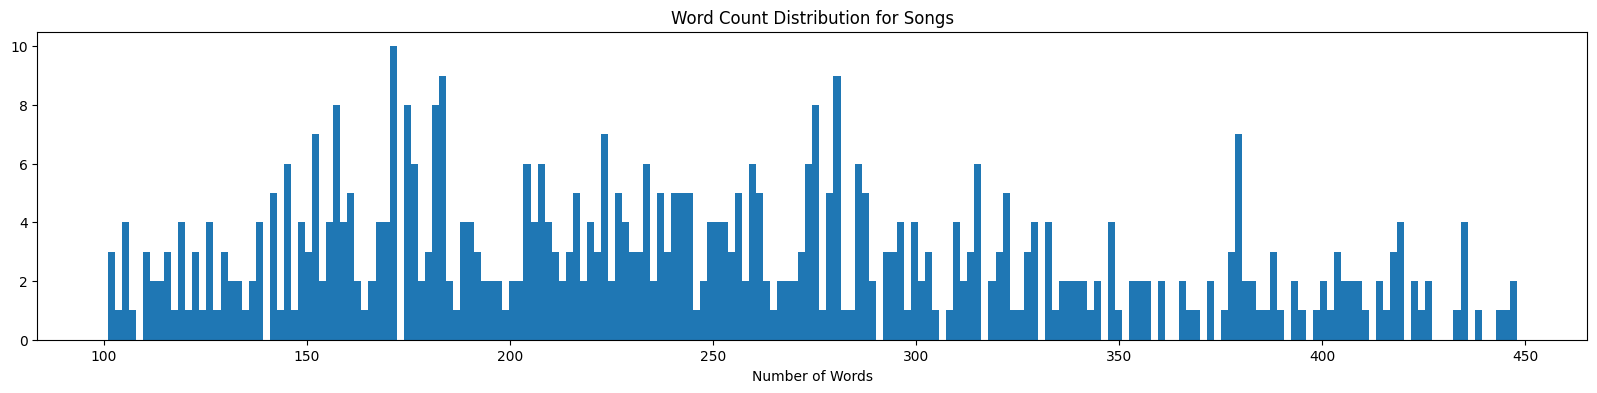

In [9]:
plt.figure(figsize = (20, 4))
plt.hist(data.NWords, bins = 200)
plt.xlabel("Number of Words")
plt.title("Word Count Distribution for Songs")

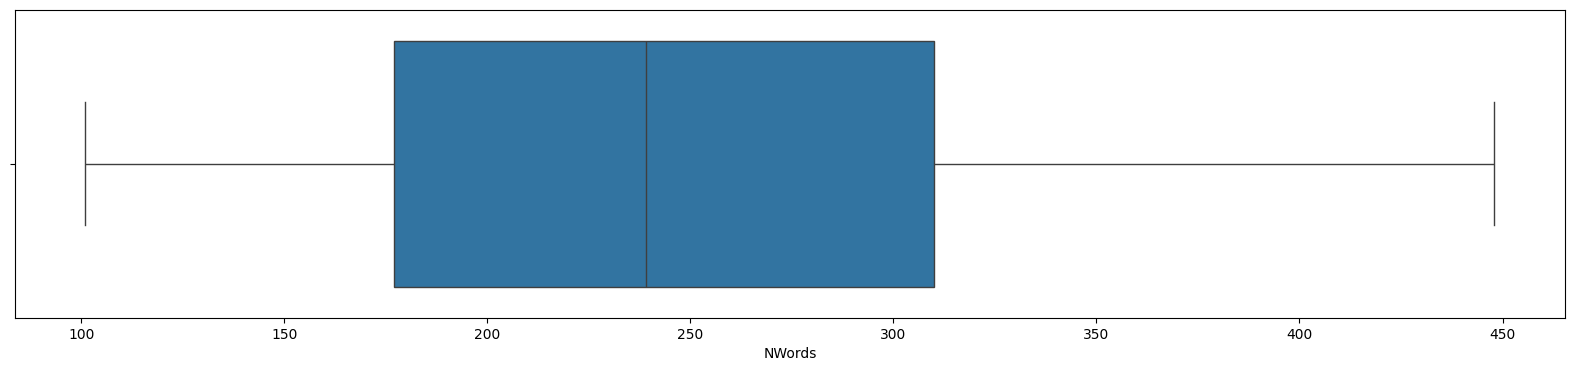

In [10]:
plt.figure(figsize = (20, 4))
sns.boxplot(x = data.NWords, orient = "horizontal")
plt.show()

### Preparing Data for Text Prediction

We will tokenise the entire dataset and convert the tokenised sentences to n-gram sequences. We will also save the tokenizer for reproducability

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.Lyric.astype(str).str.lower())
totalWords = len(tokenizer.word_index) + 1
tokenizedSentences = tokenizer.texts_to_sequences(data.Lyric.astype(str))
tokenizedSentences[0]

[9,
 893,
 35,
 42,
 202,
 2,
 23,
 28,
 121,
 9,
 337,
 196,
 223,
 87,
 242,
 3,
 228,
 154,
 16,
 10,
 88,
 2,
 2883,
 27,
 1029,
 4,
 1030,
 10,
 1999,
 44,
 13,
 2,
 28,
 44,
 17,
 6,
 3782,
 202,
 329,
 9,
 363,
 117,
 92,
 1,
 3783,
 3784,
 329,
 9,
 723,
 45,
 4,
 1,
 143,
 11,
 1,
 112,
 1,
 1224,
 2349,
 72,
 46,
 22,
 24,
 943,
 398,
 100,
 31,
 566,
 329,
 1,
 44,
 38,
 105,
 31,
 1,
 894,
 285,
 4,
 184,
 15,
 84,
 398,
 196,
 28,
 2,
 895,
 9,
 13,
 32,
 4,
 329,
 3,
 38,
 2,
 896,
 78,
 136,
 5,
 196,
 655,
 2,
 399,
 9,
 13,
 567,
 378,
 30,
 9,
 331,
 4,
 8,
 63,
 1152,
 19,
 6,
 332,
 11,
 6,
 44,
 34,
 2,
 399,
 24,
 242,
 5,
 54,
 24,
 156,
 25,
 10,
 1,
 143,
 9,
 337,
 196,
 223,
 2,
 151,
 4,
 157,
 4,
 250,
 9,
 13,
 25,
 10,
 1,
 143,
 9,
 337,
 196,
 223,
 42,
 202,
 2,
 23,
 28,
 121,
 9,
 337,
 196,
 223,
 87,
 242,
 3,
 228,
 154,
 16,
 10,
 88,
 2,
 2883,
 27,
 1029,
 4,
 1324,
 99,
 87,
 2,
 399,
 24,
 242,
 10,
 1595,
 11,
 1,
 82,
 3,
 128,
 2884,
 8,
 

In [12]:
with open("../tokenizer.pickle", "wb") as file:
    pickle.dump(tokenizer, file, protocol = pickle.HIGHEST_PROTOCOL)

In [13]:
inputSeq = []
maxLen = 0
for i in tokenizedSentences:
    for t in range(1, len(i)):
        seq = i[:t + 1]
        inputSeq.append(seq)
    maxLen = max(maxLen, len(i))

gc.collect()
inputSeq = np.array(pad_sequences(inputSeq, maxlen = maxLen, padding = "pre"))
inputSeq.shape

(133559, 1163)

Creating context (x) and target (y) variables

In [14]:
x, labels = inputSeq[:, :-1], inputSeq[:,-1]
print(x.shape)

(133559, 1162)


In [15]:
y = to_categorical(labels, num_classes = totalWords)

In [16]:
del labels


In [17]:
gc.collect()

0

## Building and Training Model

In [18]:
wordModel = Word2Vec(tokenizedSentences)
pretrainWeight = wordModel.wv.vectors
pretrainWeight.shape


(1998, 100)

In [19]:
model = Sequential([
    Embedding(totalWords, 40, input_length = maxLen - 1),
    Bidirectional(LSTM(250)),
    Dropout(0.1),
    Dense(totalWords, activation = "softmax")
])
model.compile(
    loss = "categorical_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"]
)

2023-11-21 14:55:37.641477: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-21 14:55:37.669250: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-21 14:55:37.669489: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [20]:
checkpoint = ModelCheckpoint(
    "../only_four_model.h5",
    monitor = "loss",
    verbose = 1,
    save_best_only = True,
    mode = "min"
)
es = EarlyStopping(
    monitor = "loss",
    min_delta = 0,
    patience = 3,
    verbose = 0,
    mode = "auto"
)
callbacks_list = [checkpoint, es]
history = model.fit(
    x,
    y,
    epochs=200,
    verbose=1,
    callbacks=[callbacks_list]
)

2023-11-21 14:55:38.278307: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 620782232 exceeds 10% of free system memory.
2023-11-21 14:55:38.847809: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3281277512 exceeds 10% of free system memory.
2023-11-21 14:55:41.918704: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3281277512 exceeds 10% of free system memory.


Epoch 1/200


2023-11-21 14:55:44.656420: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-21 14:55:45.239042: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa1f8488a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-21 14:55:45.239071: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-11-21 14:55:45.253324: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-21 14:55:45.348665: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4174/4174 [==============================] - ETA: 0s - loss: 5.7076 - accuracy: 0.0916
Epoch 1: loss improved from inf to 5.70756, saving model to ../only_four_model.h5


/home/darshk/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4174/4174 [==============================] - 393s 94ms/step - loss: 5.7076 - accuracy: 0.0916
Epoch 2/200
4174/4174 [==============================] - ETA: 0s - loss: 4.7310 - accuracy: 0.1806
Epoch 2: loss improved from 5.70756 to 4.73095, saving model to ../only_four_model.h5
4174/4174 [==============================] - 383s 92ms/step - loss: 4.7310 - accuracy: 0.1806
Epoch 3/200
4174/4174 [==============================] - ETA: 0s - loss: 4.0273 - accuracy: 0.2597
Epoch 3: loss improved from 4.73095 to 4.02727, saving model to ../only_four_model.h5
4174/4174 [==============================] - 363s 87ms/step - loss: 4.0273 - accuracy: 0.2597
Epoch 4/200
4174/4174 [==============================] - ETA: 0s - loss: 3.4830 - accuracy: 0.3325
Epoch 4: loss improved from 4.02727 to 3.48303, saving model to ../only_four_model.h5
4174/4174 [==============================] - 363s 87ms/step - loss: 3.4830 - accuracy: 0.3325
Epoch 5/200
4174/4174 [==============================] - ETA: 0s - lo

Training auto-stopped after around 3 hours of training over 30 epochs, since model loss stopped improving. Exporting final model

In [21]:
model.save("../only_four_final_model.h5")

/home/darshk/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Evaluating model training metrics

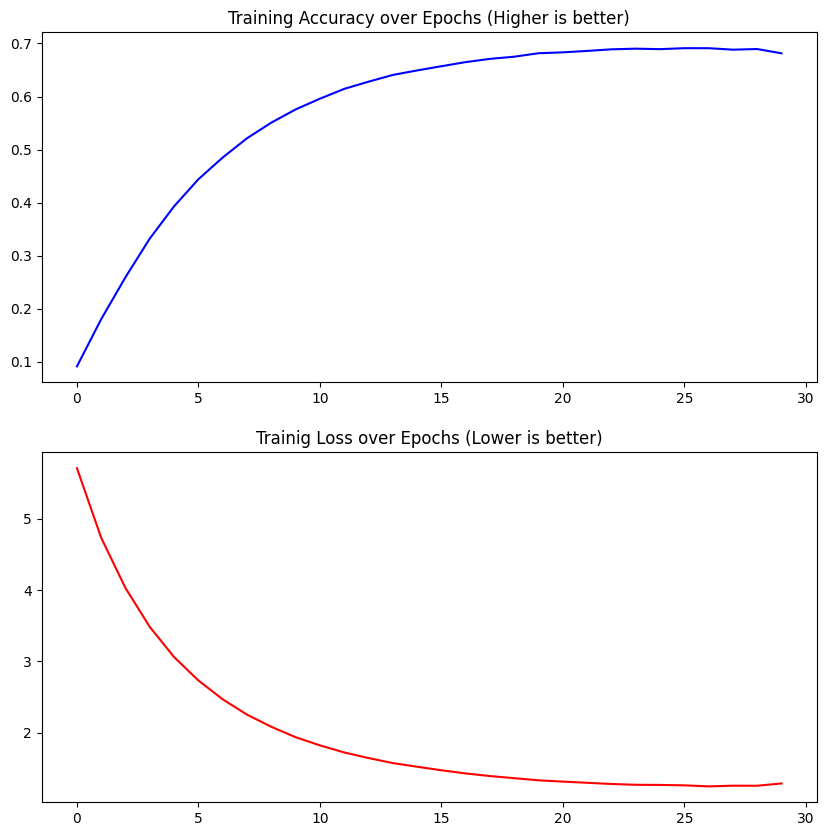

In [26]:
figure, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
ax1.plot(history.history["accuracy"], label = "train acc", color = "blue")
ax1.set_title("Training Accuracy over Epochs (Higher is better)")

ax2.plot(history.history["loss"], label = "train loss", color = "red")
ax2.set_title("Trainig Loss over Epochs (Lower is better)")
plt.show()

## Testing Model with Predictions

We will test the model based on how well it can generate lyrics from a seed text.

First we will create a function that wraps the whole process to two inputs and single output.


In [31]:
def autoCompleteSong(seedText: str, wordCount: int):
    for _ in range(wordCount):
        tokenList = tokenizer.texts_to_sequences([seedText])[0]
        tokenList = pad_sequences(
            [tokenList],
            maxlen = maxLen - 1,
            padding = "pre"
        )

        predictX = model.predict(
            tokenList,
            verbose = 0
        )
        pred = np.argmax(predictX, axis = 1)

        output = ""
        for word, index in tokenizer.word_index.items():
            if index == pred:
                output = word
                break

        seedText += " " + output
    return seedText

In [33]:
autoCompleteSong("I don't know why she's with me", 40)

"I don't know why she's with me waiting to you every night every night every night every night every night coming home to you every night every night every night every night every night every night every night every night every night every night every night every"

In [34]:
autoCompleteSong("I've been waiting a long time", 40)

"I've been waiting a long time he's been a little time i got myself jonesing and i got no breath to breathe cause it all my own anymore you can shake it all away nothing goes over 'cause i'm all gonna throw twenty memory well i"

In [35]:
autoCompleteSong("I feel there is a force", 65)

"I feel there is a force waste of sex time to bleed soon down and the time is in my mind waiting for you for this place to love real well it's harder fun tried to work tell me the words of your head saying you see that it's right at the end you couldn't try to take the easy and it's take to lose yeah i need it coming for"

## Misc Listing out values for Reference

In [36]:
print(maxLen)

1163


In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1162, 40)          245680    
                                                                 
 bidirectional (Bidirection  (None, 500)               582000    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense (Dense)               (None, 6142)              3077142   
                                                                 
Total params: 3904822 (14.90 MB)
Trainable params: 3904822 (14.90 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
